# Using the Scheduler

The scheduler will translate a `QuantumCircuit` into a Pulse `Schedule`, using gate and measurement _calibrations_: an optimized pulse-level description of an operation on particular qubits.

Backends that are OpenPulse enabled will typically have calibrations defined for measurements and for each of its basis gates. Calibrations can also be defined or updated by the user.

## Basic usage

To start, build a quantum circuit as you would normally. For our example below, we create a simple Bell state.

In [1]:
from qiskit import QuantumCircuit

circ = QuantumCircuit(1, 1)
circ = QuantumCircuit(2, 2)
circ.h(0)
circ.cx(0, 1)
circ.measure([0, 1], [0, 1])

circ.draw()

┌───┐     ┌─┐   
q_0: ┤ H ├──■──┤M├───
     └───┘┌─┴─┐└╥┘┌─┐
q_1: ─────┤ X ├─╫─┤M├
          └───┘ ║ └╥┘
c: 2/═══════════╩══╩═
                0  1

We'll use the mocked backend, `FakeAlmaden`, to demonstrate how to use the scheduler. It contains default calibrations for measurement and for its basis gates. The Hadamard operation is not one of those basis gates, so we use the transpiler to compile our input circuit to an equivalent circuit in terms of the basis gates of the device.

In [2]:
from qiskit import transpile, schedule as build_schedule
from qiskit.test.mock import FakeAlmaden

backend = FakeAlmaden()

transpiled_circ = transpile(circ, backend)  # Undefined Hadamard is replaced by U1
schedule = build_schedule(transpiled_circ, backend)

Let's see how our schedule `schedule` built from the circuit `transpiled_circ` looks. (We select a range to plot because the measurement and acquire pulses are long.)

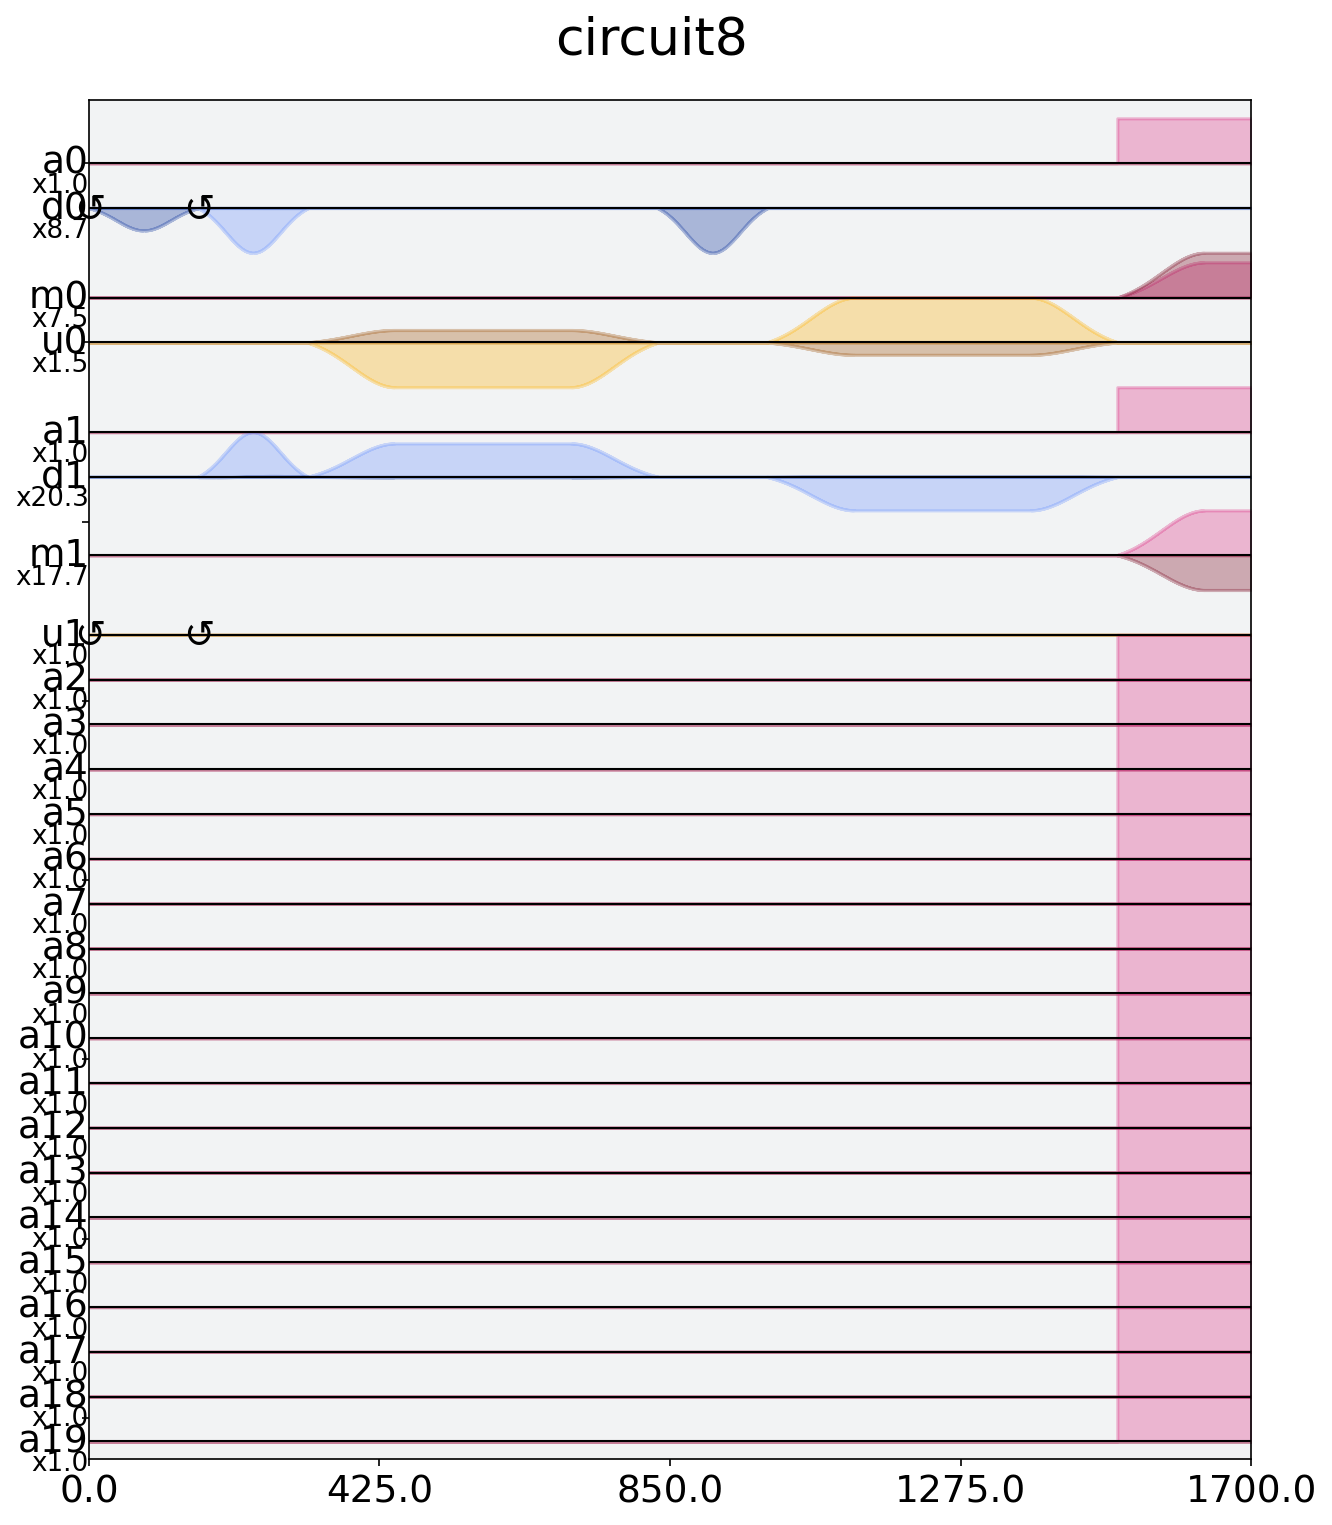

In [3]:
schedule.draw(plot_range=[0, 1700])

That covers the basics! We used the transpiler to rewrite the circuit in terms of the basis gates, and then used the backend's default calibrations to schedule the transpiled circuit. Next we will go through scheduling with calibrations we will build ourselves.

## Scheduling with custom gate definitions

Using the scheduler with Pulse, we are not restrained by the basis gates of the device. For instance, we can define a calibration for the Hadamard gate on qubit 0, which is used by our Bell state circuit. Our Hadamard will be a Gaussian pulse. In practice, the pulse shape and its parameters would be optimized through a series of Rabi experiments (see the [Qiskit Textbook](https://qiskit.org/textbook/ch-quantum-hardware/calibrating-qubits-openpulse.html) for a walk through).

In [4]:
from qiskit.pulse import Schedule, Play, Gaussian, DriveChannel

h_q0 = Schedule(Play(Gaussian(duration=128, amp=0.045, sigma=8), DriveChannel(0)))

We add the `h_q0` calibration to the backend's existing `InstructionScheduleMap` containing the instruction calibration lookup. It has to be added by gate name -- here we use the standard gate name `'h'` -- and by qubit. 
**Remember that a gate calibrated on one qubit will not enact the same gate on another qubit.**

In [5]:
inst_map = backend.defaults().instruction_schedule_map
inst_map.add('h', 0, h_q0)
inst_map2 = backend.defaults().instruction_schedule_map

schedule = build_schedule(circ, backend, inst_map=inst_map)

Notice how this time, we were able to schedule `circ`, which hasn't been transpiled, so it still has the Hadamard gate. The new `h_q0` calibration we added was used to schedule `circ`.

## Building circuits with non-standard gates

In the previous section, we added a native definition for a standard gate. In this section, we build a totally novel gate.

The first step is to create a definition for it as a Pulse `Schedule`. Below, we also demonstrate how these schedules can be built to accept parameters.

In [6]:
import numpy as np

from qiskit.pulse import Play, SamplePulse, ControlChannel
from qiskit.pulse.schedule import ParameterizedSchedule

def random_pulse(duration):
    if duration < 1:
        raise ValueError("Duration cannot be less than 1.")
    return SamplePulse(np.random.random(duration))

def random_2q_gate(x):
    sched = Schedule()
    sched += Play(random_pulse(x), DriveChannel(0))
    sched += Play(random_pulse(x), ControlChannel(0))
    sched += Play(random_pulse(x), DriveChannel(1))
    return sched

my_random_2q_gate = ParameterizedSchedule(random_2q_gate, parameters=['x'])

We call our schedule operation `'my_2q'`, and define it over qubits 0 and 1 as we add it to our calibrations.

In [7]:
inst_map.add('my_2q', (0, 1), my_random_2q_gate)

To prepare our circuit to use this definition, we need to create a new `Gate` with the same name that we defined above, `'my_2q'`.

In [8]:
from qiskit.circuit import Gate

my_2q = Gate('my_2q', num_qubits=2, params=[100])  # Here we pass `duration`, as 100

Now, we can build our circuit. When we use the new gate, `my_2q`, we `append` it to our circuit, and otherwise build the circuit normally.

In [9]:
circ = QuantumCircuit(2, 2)
circ.h(0)
circ.append(my_2q, [0, 1])
circ.h(0)
circ.measure(0, 0)
circ.draw()

┌───┐┌─────────────┐┌───┐┌─┐
q_0: ┤ H ├┤0            ├┤ H ├┤M├
     └───┘│  my_2q(100) │└───┘└╥┘
q_1: ─────┤1            ├──────╫─
          └─────────────┘      ║ 
c: 2/══════════════════════════╩═
                               0

All of the operations in `circ` are defined in our `inst_map`, so we could schedule it directly, but let's remove our qubit 0 Hadamard calibration so we can demonstrate how to use the transpiler with our novel 2Q gate.

In [10]:
inst_map.remove('h', 0)

transpiled_circ = transpile(circ,
                            coupling_map=[[0, 1]],
                            basis_gates=backend.configuration().basis_gates + ['my_2q'])
transpiled_circ.draw()

┌──────────┐┌─────────────┐┌──────────┐┌─┐
q_0 -> 0 ┤ U2(0,pi) ├┤0            ├┤ U2(0,pi) ├┤M├
         └──────────┘│  my_2q(100) │└──────────┘└╥┘
q_1 -> 1 ────────────┤1            ├─────────────╫─
                     └─────────────┘             ║ 
    c: 2/════════════════════════════════════════╩═
                                                 0

Now, we can schedule our `transpiled_circ` as we did before.

/home/computertreker/git/qiskit/qiskit-tutorial/tutorials-release/lib/python3.8/site-packages/qiskit/pulse/library/sample_pulse.py:42: DeprecationWarning: SamplePulse has been renamed to Waveform and is deprecated. Please replace SamplePulse(samples, channel) with Waveform(samples, channel).
  warnings.warn("SamplePulse has been renamed to Waveform and is deprecated. " +
/home/computertreker/git/qiskit/qiskit-tutorial/tutorials-release/lib/python3.8/site-packages/qiskit/pulse/library/sample_pulse.py:42: DeprecationWarning: SamplePulse has been renamed to Waveform and is deprecated. Please replace SamplePulse(samples, channel) with Waveform(samples, channel).
  warnings.warn("SamplePulse has been renamed to Waveform and is deprecated. " +
/home/computertreker/git/qiskit/qiskit-tutorial/tutorials-release/lib/python3.8/site-packages/qiskit/pulse/library/sample_pulse.py:42: DeprecationWarning: SamplePulse has been renamed to Waveform and is deprecated. Please replace SamplePulse(samples, c

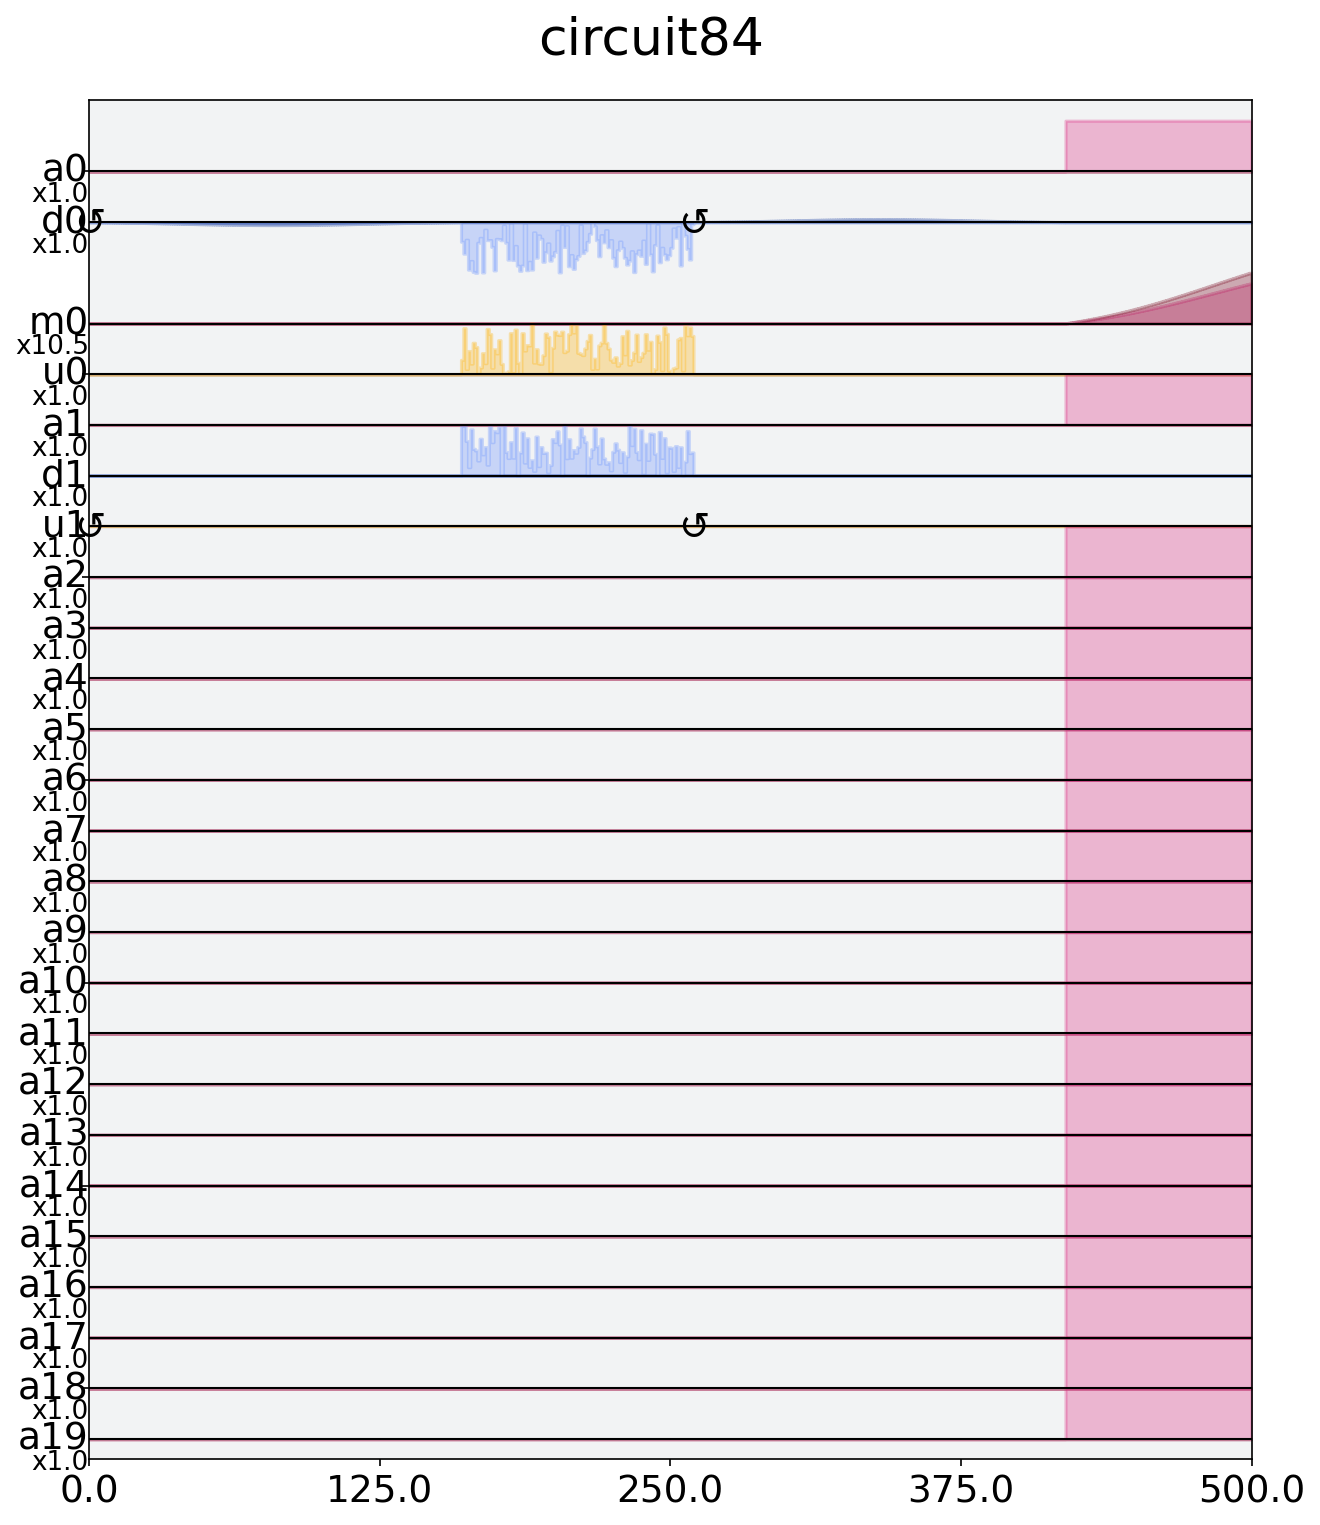

In [11]:
schedule = build_schedule(transpiled_circ, backend, inst_map=inst_map)

schedule.draw(plot_range=(0, 500))

# Scheduler methods

The scheduler can follow multiple routines. By default, it follows an _as late as possible_ (ALAP) rule. Another scheduling method is _as soon as possible_, (ASAP). For both methods, the output schedule is minimal: in the longest-duration operation path of the input circuit, the start time of each operation is the end time of the proceeding operation. The methods determine how to schedule operations outside that longest path.

This is made clear through an example:

In [12]:
circ = QuantumCircuit(2, 2)
circ.x(0)
circ.x(0)
circ.x(1)
circ.measure([0, 1], [0, 1])

For our mocked backend, these $X$ gate operations are each the same duration (`duration = 160 dt`). For the schedule to be minimal, the two $X$ operations on qubit 0 will be scheduled back-to-back, and the measurement pulse will immediately follow the second of those pulses.

ALAP will choose the latest valid time to schedule lesser-constrained operations, so the $X$ gate on qubit 1 will play in sync with the second $X$ gate on qubit 0.

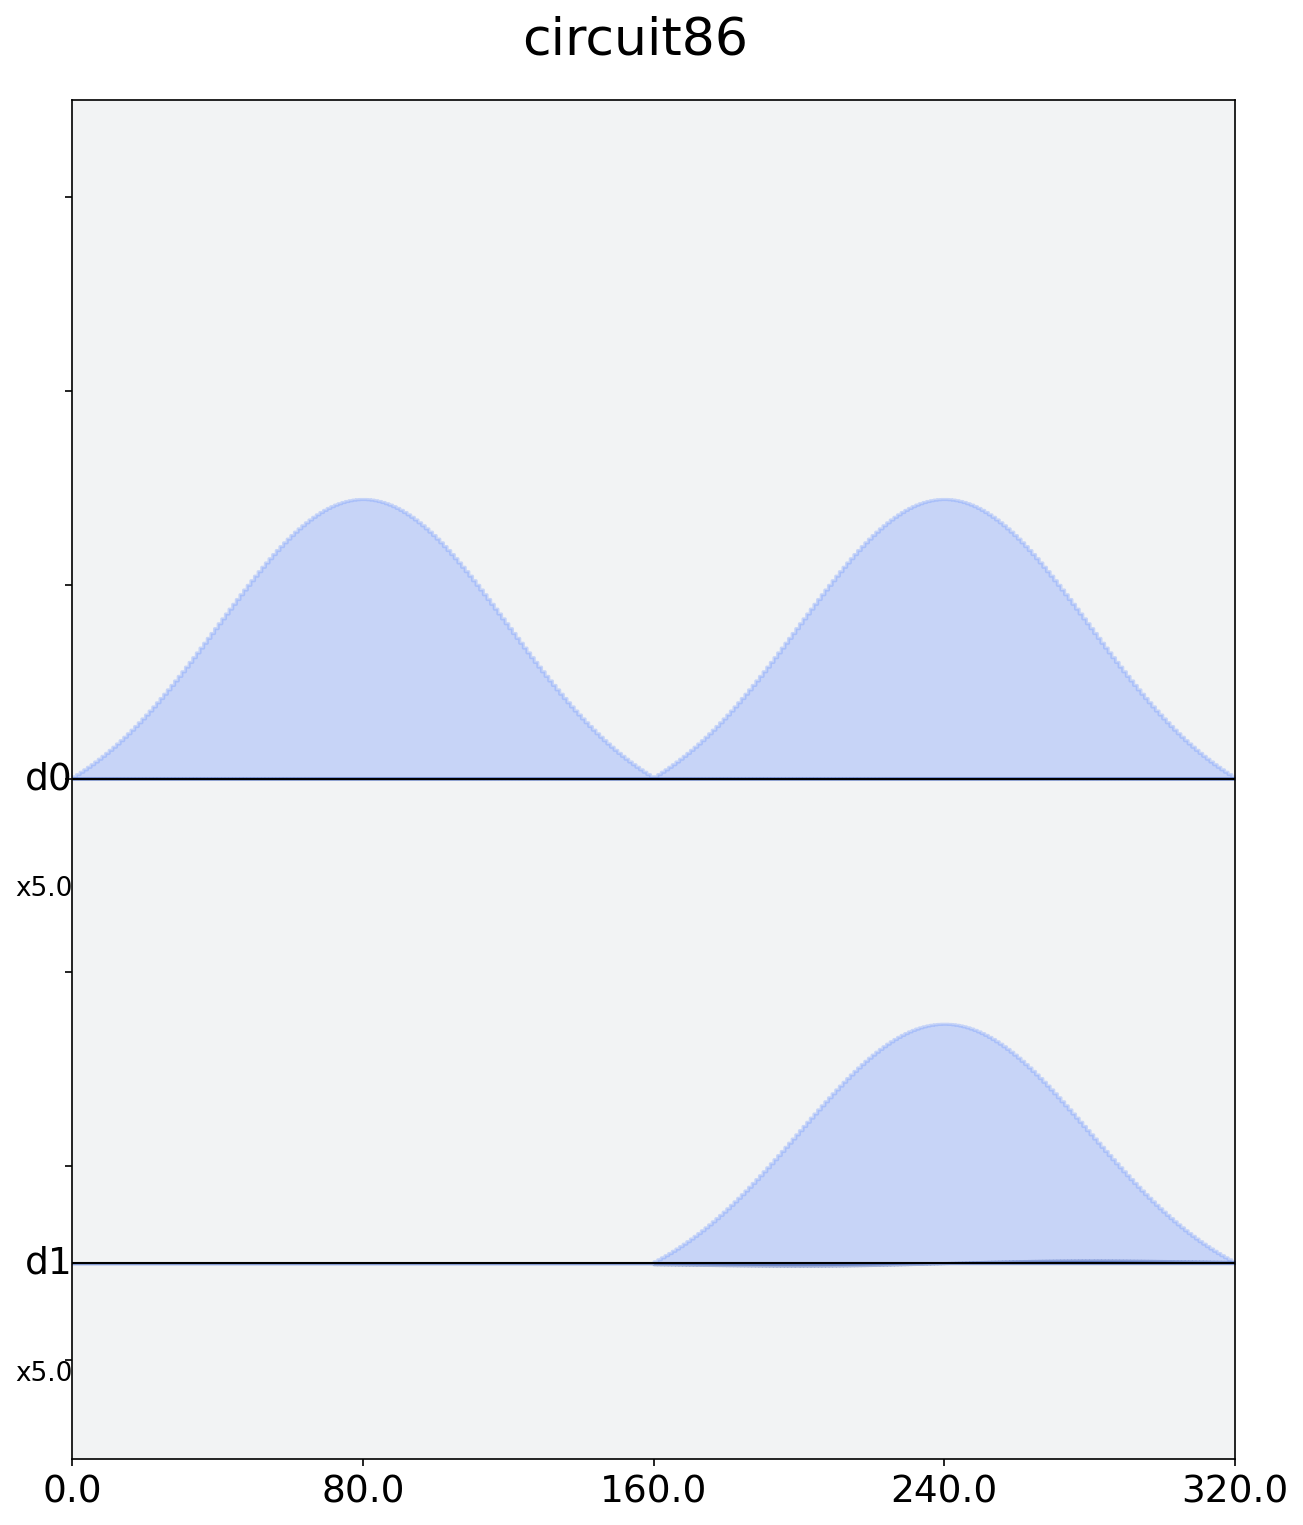

In [13]:
schedule = build_schedule(circ, backend,
                          method="as_late_as_possible")
schedule.draw(channels=[DriveChannel(0), DriveChannel(1)], scale=5)

On the other hand, as the name suggests, ASAP will schedule operations as soon as its resources are free. Thus, the $X$ gate on qubit 1 will be scheduled at `time=0`, in sync with the first $X$ gate on qubit 0.

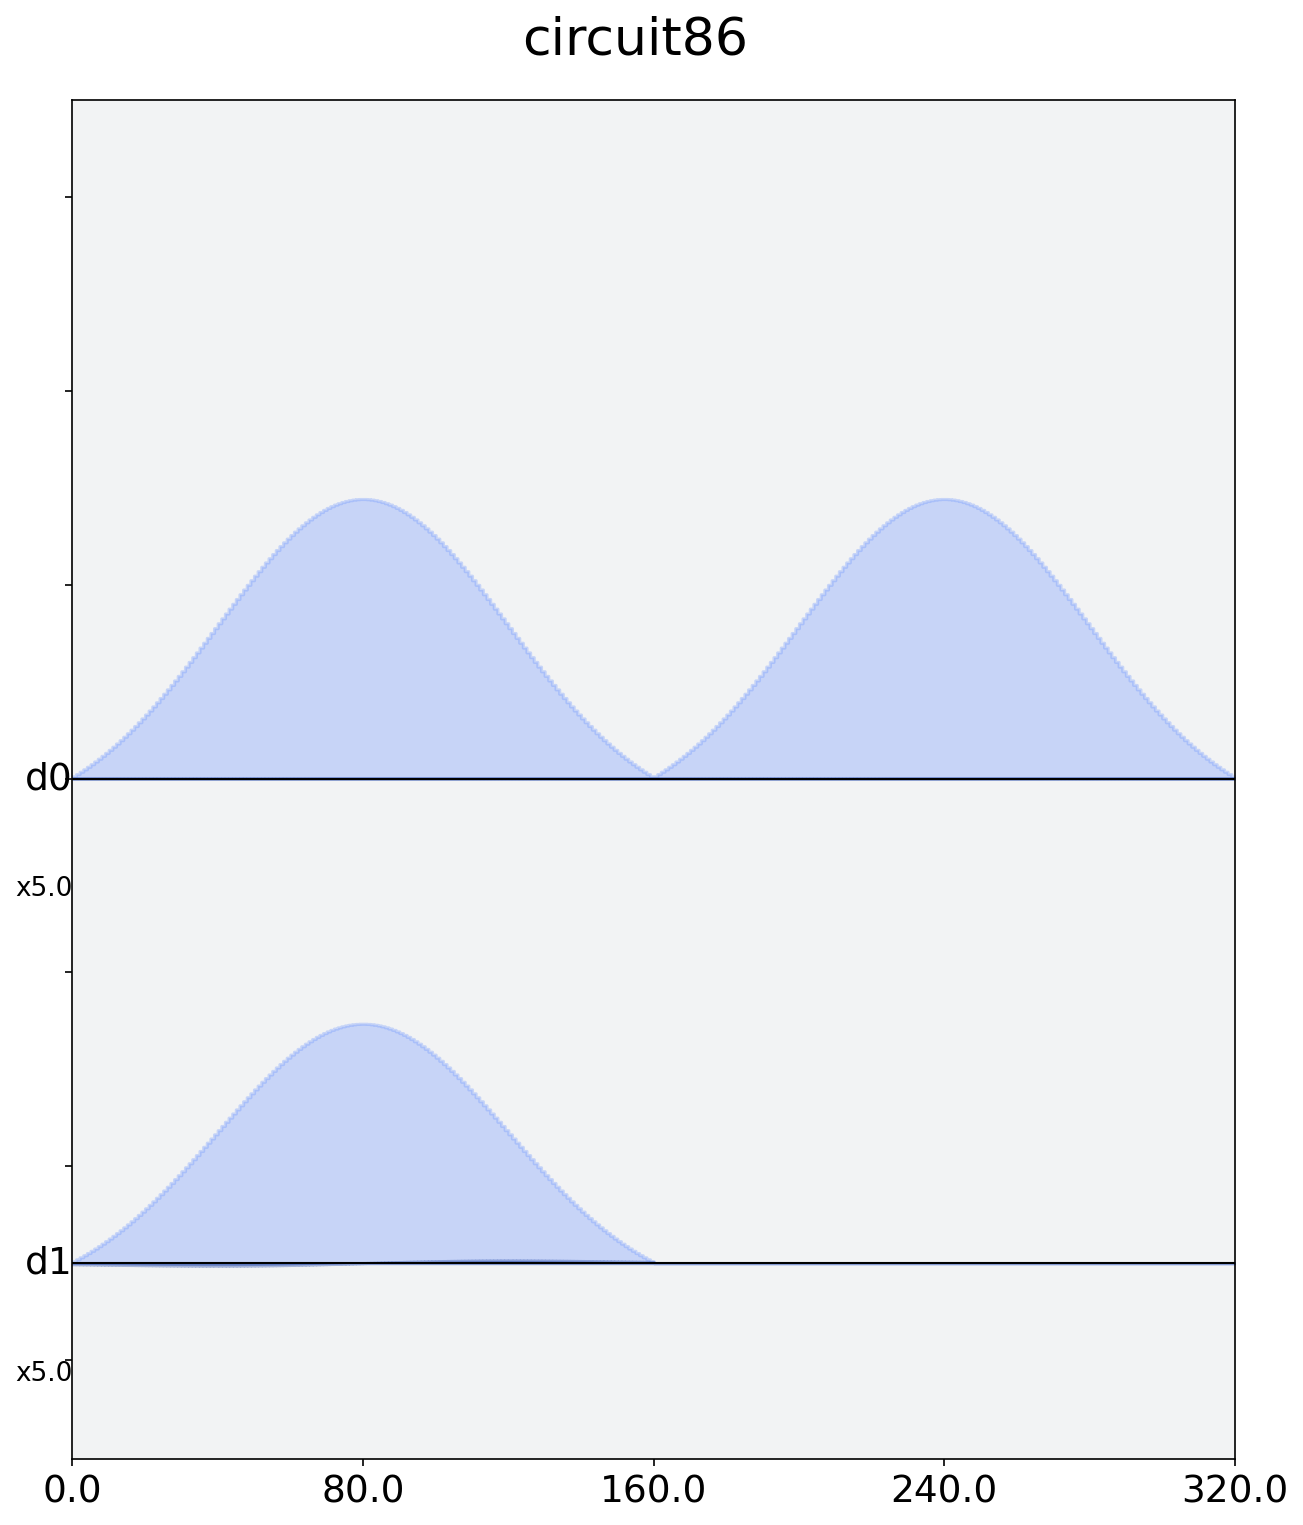

In [14]:
schedule = build_schedule(circ, backend,
                          method="as_soon_as_possible")
schedule.draw(channels=[DriveChannel(0), DriveChannel(1)], scale=5)

ALAP is the default because it allows qubits to remain idle as long as possible. In this case, the difference between ALAP and ASAP may be negligible, but in ALAP, qubit 0 has _no_ time to decay from the excited state before measurement.

In [15]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright